## Installation

To run this you need several packages. First of all, you need anaconda, which you most likely already have if you're viewing this through jupyter. If not then check the readme on the class page.

System requirements: This should work on all operating systems (Linux, Mac, and Windows). However, several of the environments in the OpenAI-gym require additional simulators which don't aren't easy to get on Windows. In any case, it is strongly recommended that you use Linux, although you should be ok with Mac. (HINT: if you're on Windows check out the Windows Subsystem for Linux (WSL), although it'll make visualizing your policies a little tricky).

Then install the following packages (using conda or pip):

- pytorch --> `conda install pytorch -c pytorch`
- gym --> `pip install gym`
- gym (the cool environments, doesnt work on Windows) --> `pip install gym[all]`
(When install gym[all] don't worry if the mujoco installation doesn't work. That's a more advanced 3D physics simulator that has to be set up separately (see website). Anyway, we don't need it necessarily).

In [1]:
# If you're using colab, this will install the necessary packages!
!pip install torch
#!pip install gym
!pip install gym==0.12.1
#!wget https://pjreddie.com/media/files/rlhw_util.py

In [2]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch import distributions
from torch.distributions import Categorical
from itertools import islice

import gym

from IPython.core.debugger import set_trace # import break point
import pickle as pkl
#%matplotlib inline

# Introduction
Welcome to the RL playground. Your task is to implement the REINFORCE and A3C algorithm to solve various OpenAI-gym environments. If you are not familiar with OpenAI-gym, stop reading and visit https://gym.openai.com/envs/ to see all the tasks you can try to solve.

In this homework, we will only look at tasks with a discrete (and small) action space. That being said, both algorithms can be modified slightly to work on tasks with continuous action spaces. For full credit you must fill in the code below so you achieve an average total reward per episode on the cartpole task (CartPole-v1) of at least 499 (for an episode length of 500) for both REINFORCE and A3C. Then you must apply your code to any one other environment in OpenAI-gym, and plot and compare the learning curves (average total reward per episode vs number of episodes trained on) between REINFORCE and A3C (where at least one of the algorithms shows significant improvement from initialization).

Below there's an overview of what every iteration will look like, regardless of whether you want to train or evaluate your agent.

In [3]:
from rlhw_util import * # <-- look whats inside here - it could save you a lot of work!

def run_iteration(mode, N, agent, gen, horizon=None, render=False):
    train = mode == 'train' 
    if train: # if mode is 'train'
        agent.train() # train the agent
    else: # if mode is not 'train'
        agent.eval() # evaluate agent

    states, actions, rewards = zip(*[gen(horizon=horizon, render=render) for _ in range(N)])
    
    #if render and renderClose:
    #    gen.env._env.close()     

    loss = None # loss initilized as None
    if train: # if mode is 'train'
        loss = agent.learn(states, actions, rewards) # loss returned from the training the agent 

    reward = sum([r.sum() for r in rewards]) / N # average over all rewards 

    return reward, loss # return avg reward and loss

## The Actor

We need to learn a policy which, given some state, outputs a distribution over all possible actions. As this is deep RL, we'll use a deep neural network to turn the observed state into the requisite action distribution. From this action distribution we can choose what action to take using `get_action`. Pytorch, brilliant as it is, makes our task incredibly easy, as we can use the `torch.distributions.Categorical` class for sampling.

You can experiment with all sorts of network architectures, but remember this is RL, not image classification on ImageNet, so you probably won't need a very deep network (HINT: look below at the state and action dimensionality to get a feel for the task).

In [4]:
# Set Model Size - Small, Medium, Large

SMALLMODEL = True
MEDMODEL = False
LARGEMODEL = False

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__() # super used to inherit functionality of parent class (nn.Module), for subclass Actor, and instance self
        
        # TODO: Fill in the code to define your policy
        
        if SMALLMODEL:
            Cin = state_dim # input layer dimension
            Cout = action_dim # output layer dimension
            hidden_dim1 = 256 # hidden layer dimension
            
            self.lin1 = nn.Linear(Cin, hidden_dim1) # linear layer
            self.lin2 = nn.Linear(hidden_dim1, Cout) # linear layer
            
            nn.init.xavier_uniform_(self.lin1.weight) # init weights 
            nn.init.xavier_uniform_(self.lin2.weight)
            
        elif MEDMODEL:
            Cin = state_dim # input layer dimension
            Cout = action_dim # output layer dimension
            hidden_dim1 = 256 # hidden layer 1 dimension
            hidden_dim2 = 512 # hidden layer 2 dimension
            hidden_dim3 = 256 # hidden layer 3 dimension
            
            self.lin1 = nn.Linear(Cin, hidden_dim1) # linear layer
            self.lin2 = nn.Linear(hidden_dim1, hidden_dim2) # linear layer
            self.lin3 = nn.Linear(hidden_dim2, hidden_dim3) # linear layer
            self.lin4 = nn.Linear(hidden_dim3, Cout) # linear layer
            
        elif LARGEMODEL:
            Cin = state_dim # input layer dimension
            Cout = action_dim # output layer dimension
            hidden_dim1 = 512 # hidden layer 1 dimension
            hidden_dim2 = 512 # hidden layer 2 dimension
            hidden_dim3 = 1024 # hidden layer 3 dimension
            hidden_dim4 = 512 # hidden layer 4 dimension
            hidden_dim5 = 512 # hidden layer 5 dimension
            
            self.lin1 = nn.Linear(Cin, hidden_dim1) # linear layer
            self.lin2 = nn.Linear(hidden_dim1, hidden_dim2) # linear layer
            self.lin3 = nn.Linear(hidden_dim2, hidden_dim3) # linear layer
            self.lin4 = nn.Linear(hidden_dim3, hidden_dim4) # linear layer
            self.lin5 = nn.Linear(hidden_dim4, hidden_dim5) # linear layer
            self.lin6 = nn.Linear(hidden_dim5, Cout) # linear layer
            
        else:
            return
        
        #raise NotImplementedError
        
    def forward(self, state):
        
        # TODO: Fill in the code to run a forward pass of your policy to get a distribution over actions (HINT: probabilities sum to 1)
        
        if SMALLMODEL:
            state = F.relu(self.lin1(state)) # use relu transistion function
            state = F.relu(self.lin2(state)) # use relu transistion function
            return F.softmax(state, dim=-1) # sum probs to 1
        
        elif MEDMODEL:
            state = F.relu(self.lin1(state)) # use relu transistion function
            state = F.relu(self.lin2(state)) # use relu transistion function
            state = F.relu(self.lin3(state)) # use relu transistion function
            state = F.relu(self.lin4(state)) # use relu transistion function
            return F.softmax(state, dim=-1) # sum probs to 1
        
        elif LARGEMODEL:
            state = F.relu(self.lin1(state)) # use relu transistion function
            state = F.relu(self.lin2(state)) # use relu transistion function
            state = F.relu(self.lin3(state)) # use relu transistion function
            state = F.relu(self.lin4(state)) # use relu transistion function
            state = F.relu(self.lin5(state)) # use relu transistion function
            state = F.relu(self.lin6(state)) # use relu transistion function
            return F.softmax(state, dim=-1) # sum probs to 1
            
        else:
            return
            
        #raise NotImplementedError

    def get_policy(self, state):
        return Categorical(self(state))

    def get_action(self, state, greedy=None):
        if greedy is None:
            greedy = not self.training

        policy = self.get_policy(state)
        return MLE(policy) if greedy else policy.sample()

## The REINFORCE Agent

The Actor defines our policy, but we also have to define how and when we'll be updating our policy, which brings us to the agent. The agent will house the policy (an `Actor`), and can then be used to generate rollouts (using `forward()`) or update the policy given a list of rollouts (using `learn()`).

The REINFORCE algorithm naively uses the returns directly to weight the gradients, however this makes the variance in the policy gradient estimation very large. As a result, we will use a baseline which is a linear model which takes in a state and outputs the return (sounds like a value function, right?). Except we're not going to train our baseline using gradient descent, instead we'll just solve the linear system analytically in every iteration, and use the solution in the next iteration. Don't worry about training/updating the baseline, but you do have to use it in the right way. (Optional experiment: try removing the baseline and see how performance changes)

In [6]:
class REINFORCE(nn.Module):
    
    def __init__(self, state_dim, action_dim, discount=0.97, lr=1e-3, weight_decay=1e-4):
        super(REINFORCE, self).__init__()
        self.actor = Actor(state_dim, action_dim)
        
        self.baseline = nn.Linear(state_dim, 1)
        
        # TODO: create an optimizer for the parameters of your actor (HINT: use the passed in lr and weight_decay args)
        
        # create optimizer for actor
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay) #https://pytorch.org/docs/stable/optim.html

        #raise NotImplementedError
    
        self.discount = discount
        
    def forward(self, state):
        return self.actor.get_action(state)
    
    def learn(self, states, actions, rewards):
        '''
        Takes in three arguments each of which is a list with equal length. Each element in the list is a 
        pytorch tensor with 1 row for every step in the episode, and the columns are state_dim, action_dim, 
        and 1, respectively.
        '''
        
        # TODO: implement the REINFORCE algorithm (HINT: check the slides/papers)
        
        returns = [compute_returns(rs, discount=self.discount) for rs in rewards]
        
        states, actions, returns = torch.cat(states), torch.cat(actions), torch.cat(returns)
        
        self.optimizer.zero_grad() # https://pytorch.org/docs/stable/optim.html
        
        lossSum = 0 # init loss to 0
        for i in range(len(states)): # iterate through state, action, reward for single episode 
            s = states[i] # get state
            a = actions[i] # get action
            r = returns[i] # get associated reward

            pi = self.actor.get_policy(s) # get the policy pi
            
            # calculate the loss and update the loss sum
            loss = -pi.log_prob(a) * r # https://pytorch.org/docs/stable/distributions.html
            lossSum += loss
        
        lossSum.backward() # back prop gradient
        self.optimizer.step() # update parameters
            
        #raise NotImplementedError
        
        error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()
        solve(states, returns, out=self.baseline)
        #error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()
        
        return error.item() # Returns a rough estimate of the error in the baseline (dont worry about this too much)

## The Critic

Now we can introduce a critic, which is essentially a value function to estimate the expected discounted reward of a state.

In [7]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        
        # TODO: define your value function network
        Cin = state_dim # input layer dimension
        Cout = 1 # output layer dimension - 1 for single value
        hidden_dim1 = 256 # hidden layer dimension
        #hidden_dim2 = 256

        self.lin1 = nn.Linear(Cin, hidden_dim1) # linear layer
        self.lin2 = nn.Linear(hidden_dim1, Cout) # linear layer
        #self.lin3 = nn.Linear(hidden_dim2, Cout) # linear layer
        
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)
        #nn.init.xavier_uniform_(self.lin3.weight)

        #raise NotImplementedError

    def forward(self, state):
        
        # TODO: apply your value function network to get a value given this batch of states
        state = F.relu(self.lin1(state)) # use relu transistion function
        state = F.relu(self.lin2(state)) # use relu transistion function
        #state = F.relu(self.lin3(state)) # use relu transistion function
        return F.softmax(state, dim=-1) # sum probs to 1
        
        #raise NotImplementedError

## The A3C Agent

Now we can put the actor and critic together using the A3C algorithm. It turns out, the tasks in the gym are all so simple that there is essentially no gain in parallelization, so technically we're implementing A2C (no async), but the RL part is the same.

In [8]:
class A3C(nn.Module):
    
    def __init__(self, state_dim, action_dim, discount=0.97, lr=1e-3, weight_decay=1e-4):
        super(A3C, self).__init__()
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        
        # TODO: create an optimizer for the parameters of your actor (HINT: use the passed in lr and weight_decay args)
        # (HINT: the actor and critic have different objectives, so how many optimizers do you need?)
        
        self.baseline = nn.Linear(state_dim, 1) # adapted from actor code
        
        # Create 2 optimizers, one for the actor, one for the critic (assume same lr and weight decay)
        self.optimizerAct = optim.Adam(self.actor.parameters(), lr=lr, weight_decay=weight_decay) # create optimized for actor
        self.optimizerCrit = optim.Adam(self.critic.parameters(), lr=lr, weight_decay=weight_decay) # create optimized for critic

        #raise NotImplementedError
    
        self.discount = discount
        
    def forward(self, state):
        return self.actor.get_action(state)
    
    def learn(self, states, actions, rewards):
        
        returns = [compute_returns(rs, discount=self.discount) for rs in rewards]
        
        states, actions, returns = torch.cat(states), torch.cat(actions), torch.cat(returns)
        
        # TODO: implement A3C (HINT: algorithm details found in A3C paper supplement) 
        # (HINT2: the algorithm is actually very similar to REINFORCE, the only difference is now we have a critic, what might that do?)
        
        # reset gradient for each back prop
        self.optimizerAct.zero_grad() # https://pytorch.org/docs/stable/optim.html
        self.optimizerCrit.zero_grad()
        
        lossSum = 0.0 # init loss sum to 0
        for i in range(len(states)): # iterate through state, action, reward for single episode 
            s = states[i] # get state
            a = actions[i] # get action
            r = returns[i] # get associated reward
            
            # We used the pseudocode from the paper (page 14): https://arxiv.org/pdf/1602.01783.pdf
            V = self.critic(s)
            R = r + self.discount * V # check terminal state case??????????
            pi = self.actor.get_policy(s) # get the policy pi
            
            # adapted from Google Deep Minds 'Asynchronous Methods for Deep Reinforcement Learning'
            actLoss = -pi.log_prob(a) * (R - V)
            critLoss = -(R - V) ** 2 
            #critLoss = 0
            lossSum += actLoss + critLoss # sum the loss
            
        lossSum.backward() # back prop
        self.optimizerAct.step() # update actor
        self.optimizerCrit.step() # update critic
        
        error = F.mse_loss(self.baseline(states).squeeze(), returns).detach() # adapted from given code for actor 
        solve(states, returns, out=self.baseline)
        #error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()
        
        return error.item() # Returns a rough estimate of the error in the baseline (dont worry about this too much)
        
        #raise NotImplementedError

## Part 1: Balancing a pole with a cart

First, we'll test both algorithms on a very simple toy system: the cartpole. Eventhough it's very low dimensional (state=4, action=2), this task is nontrival because it is underactuated. Nevertheless after a few thousand episodes our policy shouldn't have a problem! 

In [9]:
# Optimization hyperparameters
lr = 1e-3
weight_decay = 1e-4

In [10]:
# Choose and then generate the environement

#env_name = 'CartPole-v1' 
env_name = 'LunarLander-v2'
#env_name = 'Acrobot-v1'

e = Pytorch_Gym_Env(env_name)
state_dim = e.observation_space.shape[0]
action_dim = e.action_space.n

In [11]:
# Choose what agent to use

agent = REINFORCE(state_dim, action_dim, lr=lr, weight_decay=weight_decay)
#agent = A3C(state_dim, action_dim, lr=lr, weight_decay=weight_decay)

total_episodes = 0
print(agent) # Let's take a look at what we're working with...

REINFORCE(
  (actor): Actor(
    (lin1): Linear(in_features=8, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=4, bias=True)
  )
  (baseline): Linear(in_features=8, out_features=1, bias=True)
)


In [12]:
# Create the environement / agent 
gen = Generator(e, agent)

### Let's do this!!

Below is the loop to train and evaluate your agent. You can play around with the number of iterations to run, and the number of rollouts per iteration. 

You can rerun this cell multiple times to keep training your model for more episodes. In any case, it shouldn't take more than 30 min to an 1 hour to train. (training never took me more than 5 min). HINT: Keep an eye on the eval_reward, it'll be pretty noisy, but if that should be slowly increasing.

In [13]:
# FILES TO SAVE MODEL DATA

# REINFORCE Files 
#file_name = 'data/cartpoleREINFORCE.pkl'
file_name = 'data/lunarlanderREINFORCE.pkl'
#file_name = 'data/acrobatREINFORCE.pkl'

# A3C Files
#file_name = 'data/cartpoleA3C.pkl'
#file_name = 'data/lunarlanderA3C.pkl'
#file_name = 'data/acrobatA3C.pkl'

# Lists for model training plotting information
episodeList = []
totalRewardList = []
trainLossList = []
evalRewardList = []

In [18]:
num_iter = 100 # for normal training - 1000 episodes 
#num_iter = 500 # for longer training - 5000 episodes 
num_train = 10
num_eval = 10 # dont change this

for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    #train_reward, train_loss = run_iteration('train', num_train, agent, gen, render=True)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    
    # add values to plotting lists
    episodeList.append(total_episodes)
    totalRewardList.append(train_reward)
    trainLossList.append(train_loss)
    evalRewardList.append(eval_reward)
    
    # Cart Pole
    if eval_reward > 499 and env_name == 'CartPole-v1': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
        break
    
    # Acrobot
#     if env_name == 'Acrobot-v1':
#         if len(episodeList) > 10:
#             if evalRewardList[-1] > -100:
#                 if evalRewardList[-2] > -100: 
#                     if evalRewardList[-3] > -100:
#                         if evalRewardList[-4] > -100:
#                             print('solved acrobat!')
#                             break


print('Done Training')

# save model
print('Saving Metrics to Plot')

# dictionary to hold all model data
plotDict = {}
plotDict['episodeList'] = episodeList
plotDict['totalRewardList'] = totalRewardList
plotDict['trainLossList'] = trainLossList
plotDict['evalRewardList'] = evalRewardList

# dump values to pickle file for storage
with open(file_name, 'wb') as pklOutput:
    pkl.dump(plotDict, pklOutput, pkl.HIGHEST_PROTOCOL)

print('All Metrics Saved')
    
    
    

Ep:1010: reward=-163.445, loss=1524.259, eval=-112.712
Ep:1020: reward=-186.704, loss=2059.410, eval=-131.384
Ep:1030: reward=-178.571, loss=849.365, eval=-123.640
Ep:1040: reward=-142.555, loss=1040.354, eval=-140.838
Ep:1050: reward=-115.192, loss=288.891, eval=-136.938
Ep:1060: reward=-134.508, loss=411.461, eval=-139.844
Ep:1070: reward=-127.525, loss=422.880, eval=-130.351
Ep:1080: reward=-135.562, loss=1304.566, eval=-132.395
Ep:1090: reward=-121.352, loss=590.033, eval=-133.777
Ep:1100: reward=-138.928, loss=469.249, eval=-97.295
Ep:1110: reward=-175.541, loss=1197.467, eval=-149.867
Ep:1120: reward=-148.641, loss=1854.601, eval=-124.848
Ep:1130: reward=-172.995, loss=1442.870, eval=-127.122
Ep:1140: reward=-139.176, loss=301.666, eval=-123.687
Ep:1150: reward=-164.573, loss=277.244, eval=-116.113
Ep:1160: reward=-160.648, loss=794.201, eval=-137.771
Ep:1170: reward=-158.812, loss=625.821, eval=-135.328
Ep:1180: reward=-151.449, loss=294.282, eval=-109.595
Ep:1190: reward=-130.6

In [22]:
# You can visualize your policy at any time
avgReward, avgLoss = run_iteration('eval', 5, agent, gen, render=True)
print(avgReward, avgLoss)

tensor(-131.0362) None


### Analysis

Plot the performance of each of your agents for the cartpole task and one additional task. When choosing a new environment, make sure is has a discrete action space. For each plot the x axis should show the total number of episodes the model was trained on, and the y axis shows the average total reward per episode.

You can leave the plots as cell outputs below, or you can save them as images and submit them separately.

### Deliverables
- single plot showing both the REINFORCE algorithm's performance, and A3C's performance on the same plot for the cartpole environment (CartPole-v1).
- single plot showing both the REINFORCE algorithm's performance, and A3C's performance on the same plot for a second environment of your choice (suggested -> LunarLander-v2, it's a little tricky but watching the agent fly spaceships is very entertaining!).
- in every case you models have to learn something for full credit.

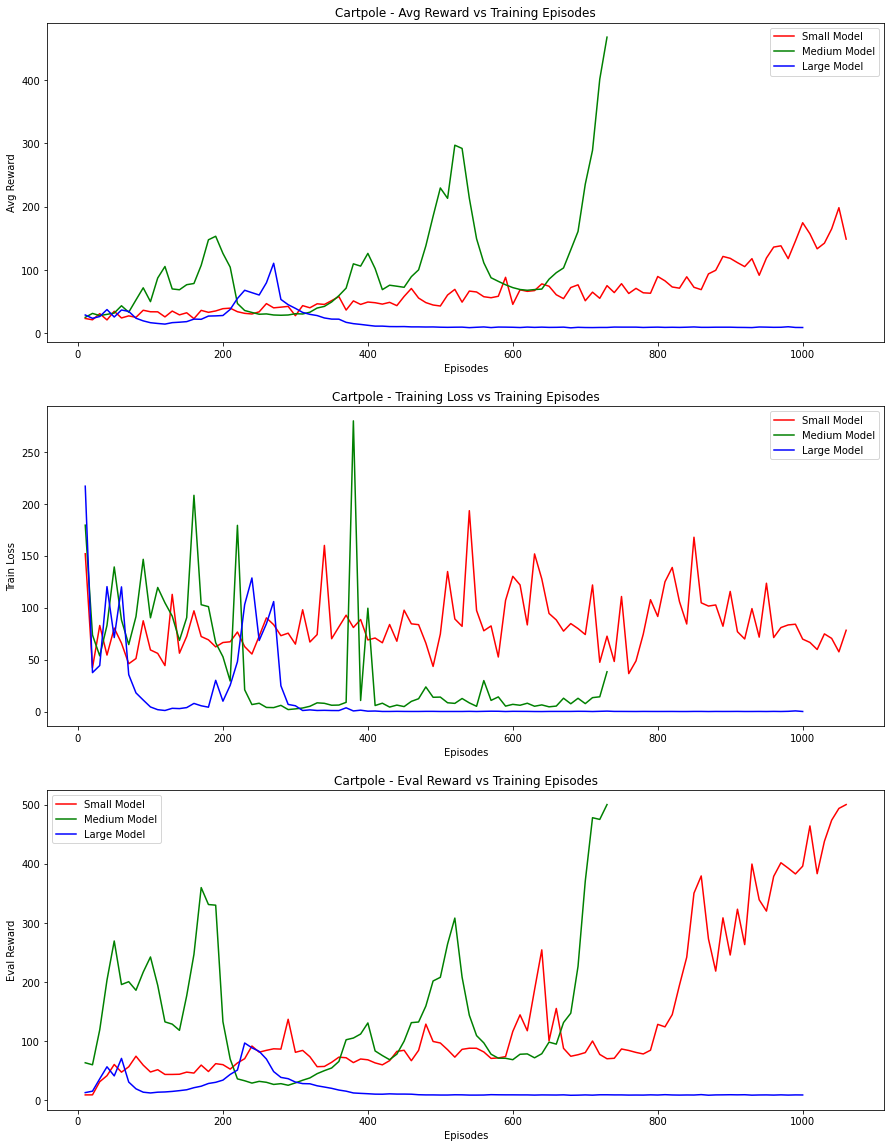

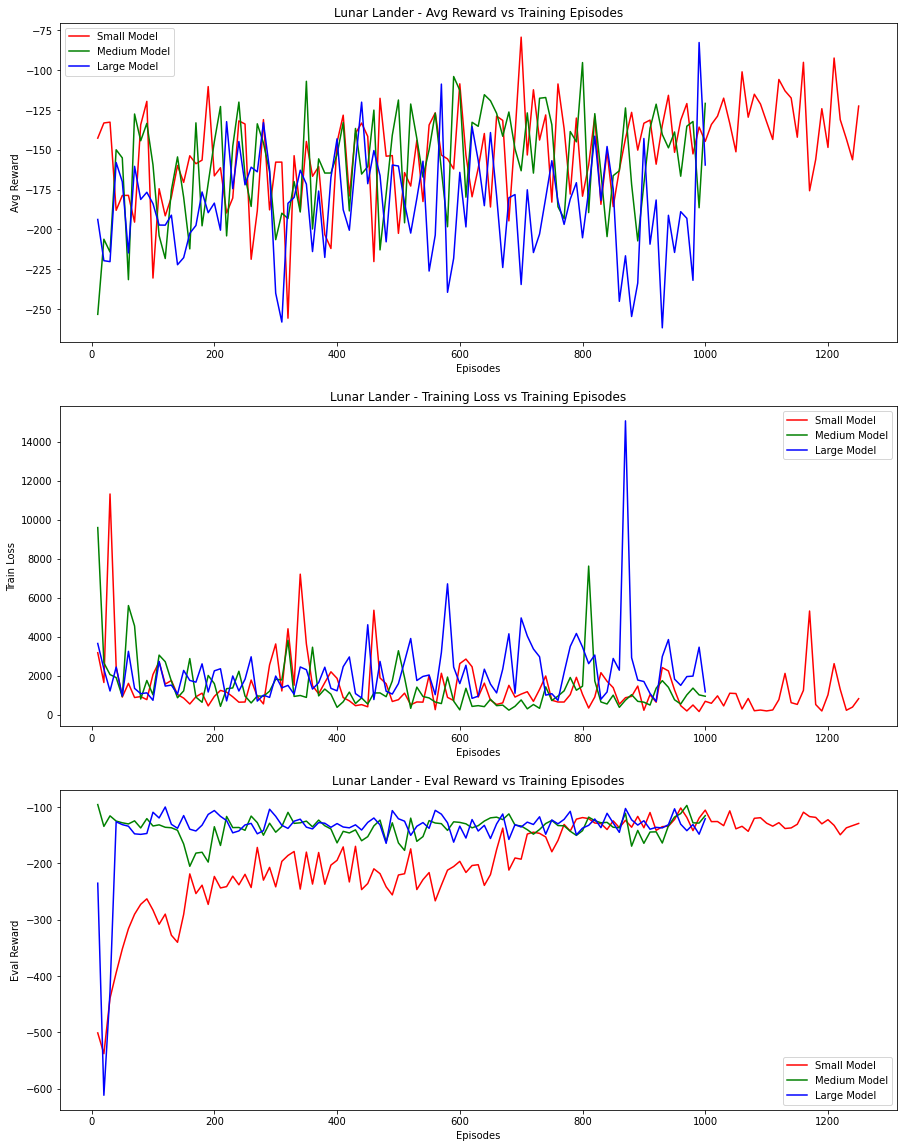

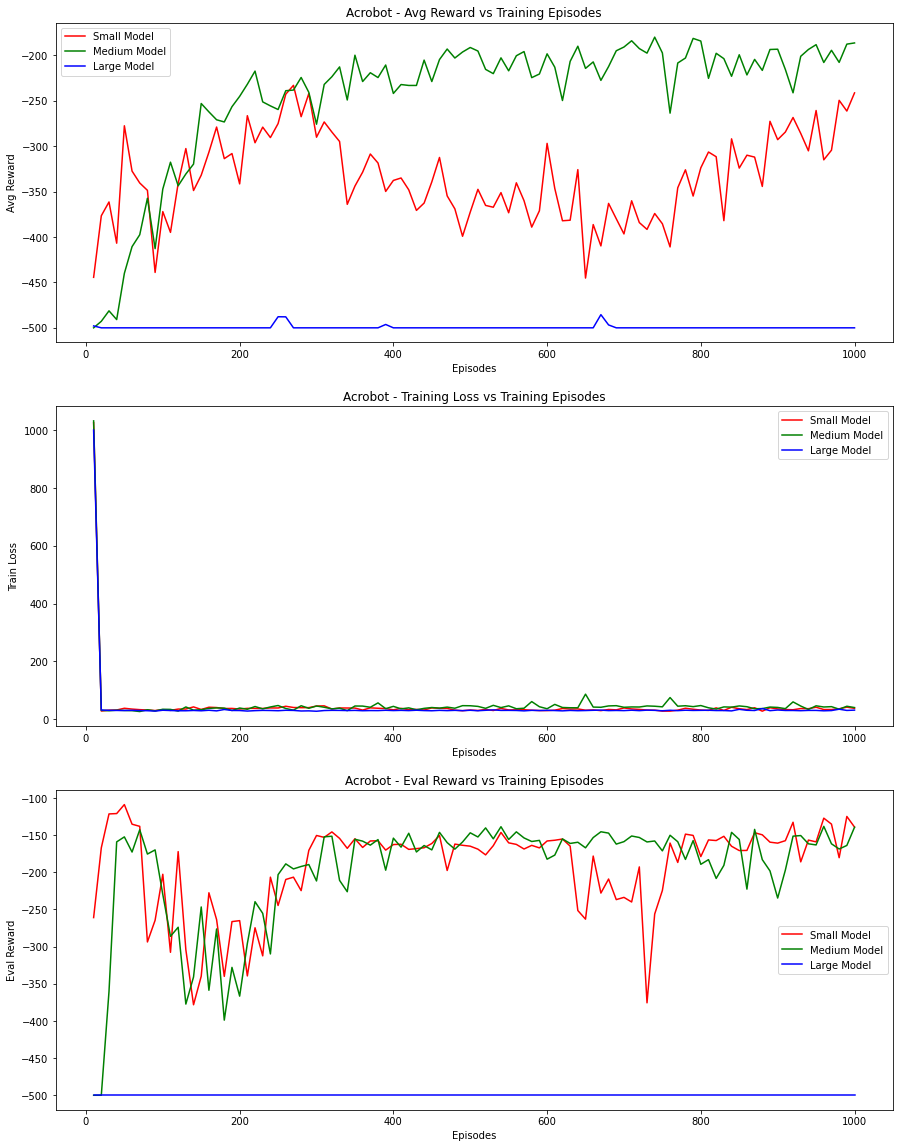

In [16]:
CARTPOLE = True
LUNARLANDER = True
ACROBAT = True

if CARTPOLE:
    with open('data/cartpoleREINFORCE_smallmodel.pkl', 'rb') as cartpoleREINFORCE_smallmodel:
        cpRDict_sml = pkl.load(cartpoleREINFORCE_smallmodel)
        cpREINFORCE_sml_episode = cpRDict_sml['episodeList']
        cpREINFORCE_sml_totalReward = cpRDict_sml['totalRewardList']
        cpREINFORCE_sml_trainLoss = cpRDict_sml['trainLossList']
        cpREINFORCE_sml_evalReward = cpRDict_sml['evalRewardList']
        
    with open('data/cartpoleREINFORCE_medmodel.pkl', 'rb') as cartpoleREINFORCE_mediummodel:
        cpRDict_med = pkl.load(cartpoleREINFORCE_mediummodel)
        cpREINFORCE_med_episode = cpRDict_med['episodeList']
        cpREINFORCE_med_totalReward = cpRDict_med['totalRewardList']
        cpREINFORCE_med_trainLoss = cpRDict_med['trainLossList']
        cpREINFORCE_med_evalReward = cpRDict_med['evalRewardList']
        
    with open('data/cartpoleREINFORCE_largemodel.pkl', 'rb') as cartpoleREINFORCE_largemodel:
        cpRDict_lrg = pkl.load(cartpoleREINFORCE_largemodel)
        cpREINFORCE_lrg_episode = cpRDict_lrg['episodeList']
        cpREINFORCE_lrg_totalReward = cpRDict_lrg['totalRewardList']
        cpREINFORCE_lrg_trainLoss = cpRDict_lrg['trainLossList']
        cpREINFORCE_lrg_evalReward = cpRDict_lrg['evalRewardList']
    
    plt.figure(figsize=(15,20))
    plt.tight_layout()
    
    plt.subplot(3,1,1)
    plt.plot(cpREINFORCE_sml_episode, cpREINFORCE_sml_totalReward,'r', label='Small Model')
    plt.plot(cpREINFORCE_med_episode, cpREINFORCE_med_totalReward,'g', label='Medium Model')
    plt.plot(cpREINFORCE_lrg_episode, cpREINFORCE_lrg_totalReward,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Cartpole - Avg Reward vs Training Episodes')
    
    plt.subplot(3,1,2)
    plt.plot(cpREINFORCE_sml_episode, cpREINFORCE_sml_trainLoss,'r', label='Small Model')
    plt.plot(cpREINFORCE_med_episode, cpREINFORCE_med_trainLoss,'g', label='Medium Model')
    plt.plot(cpREINFORCE_lrg_episode, cpREINFORCE_lrg_trainLoss,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Train Loss')
    plt.title('Cartpole - Training Loss vs Training Episodes')
    
    plt.subplot(3,1,3)
    plt.plot(cpREINFORCE_sml_episode, cpREINFORCE_sml_evalReward,'r', label='Small Model')
    plt.plot(cpREINFORCE_med_episode, cpREINFORCE_med_evalReward,'g', label='Medium Model')
    plt.plot(cpREINFORCE_lrg_episode, cpREINFORCE_lrg_evalReward,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Eval Reward')
    plt.title('Cartpole - Eval Reward vs Training Episodes')
    
    plt.savefig('outputImgs/CP_model_size.png')

    
    
if LUNARLANDER:
    with open('data/lunarlanderREINFORCE_smallmodel.pkl', 'rb') as lunarlanderREINFORCE_smallmodel:
        llRDict_sml = pkl.load(lunarlanderREINFORCE_smallmodel)
        llREINFORCE_sml_episode = llRDict_sml['episodeList']
        llREINFORCE_sml_totalReward = llRDict_sml['totalRewardList']
        llREINFORCE_sml_trainLoss = llRDict_sml['trainLossList']
        llREINFORCE_sml_evalReward = llRDict_sml['evalRewardList']
        
    with open('data/lunarlanderREINFORCE_medmodel.pkl', 'rb') as lunarlanderREINFORCE_mediummodel:
        llRDict_med = pkl.load(lunarlanderREINFORCE_mediummodel)
        llREINFORCE_med_episode = llRDict_med['episodeList']
        llREINFORCE_med_totalReward = llRDict_med['totalRewardList']
        llREINFORCE_med_trainLoss = llRDict_med['trainLossList']
        llREINFORCE_med_evalReward = llRDict_med['evalRewardList']
        
    with open('data/lunarlanderREINFORCE_largemodel.pkl', 'rb') as lunarlanderREINFORCE_largemodel:
        llRDict_lrg = pkl.load(lunarlanderREINFORCE_largemodel)
        llREINFORCE_lrg_episode = llRDict_lrg['episodeList']
        llREINFORCE_lrg_totalReward = llRDict_lrg['totalRewardList']
        llREINFORCE_lrg_trainLoss = llRDict_lrg['trainLossList']
        llREINFORCE_lrg_evalReward = llRDict_lrg['evalRewardList']
 
    plt.figure(figsize=(15,20))
    plt.tight_layout()
    
    plt.subplot(3,1,1)
    plt.plot(llREINFORCE_sml_episode, llREINFORCE_sml_totalReward,'r', label='Small Model')
    plt.plot(llREINFORCE_med_episode, llREINFORCE_med_totalReward,'g', label='Medium Model')
    plt.plot(llREINFORCE_lrg_episode, llREINFORCE_lrg_totalReward,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Lunar Lander - Avg Reward vs Training Episodes')
    
    plt.subplot(3,1,2)
    plt.plot(llREINFORCE_sml_episode, llREINFORCE_sml_trainLoss,'r', label='Small Model')
    plt.plot(llREINFORCE_med_episode, llREINFORCE_med_trainLoss,'g', label='Medium Model')
    plt.plot(llREINFORCE_lrg_episode, llREINFORCE_lrg_trainLoss,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Train Loss')
    plt.title('Lunar Lander - Training Loss vs Training Episodes')
    
    plt.subplot(3,1,3)
    plt.plot(llREINFORCE_sml_episode, llREINFORCE_sml_evalReward,'r', label='Small Model')
    plt.plot(llREINFORCE_med_episode, llREINFORCE_med_evalReward,'g', label='Medium Model')
    plt.plot(llREINFORCE_lrg_episode, llREINFORCE_lrg_evalReward,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Eval Reward')
    plt.title('Lunar Lander - Eval Reward vs Training Episodes')
    
    plt.savefig('outputImgs/LL_model_size.png')
  
    
    
if ACROBAT:
    with open('data/acrobatREINFORCE_smallmodel.pkl', 'rb') as acrobatREINFORCE_smallmodel:
        abRDict_sml = pkl.load(acrobatREINFORCE_smallmodel)
        abREINFORCE_sml_episode = abRDict_sml['episodeList']
        abREINFORCE_sml_totalReward = abRDict_sml['totalRewardList']
        abREINFORCE_sml_trainLoss = abRDict_sml['trainLossList']
        abREINFORCE_sml_evalReward = abRDict_sml['evalRewardList']
        
    with open('data/acrobatREINFORCE_medmodel.pkl', 'rb') as acrobatREINFORCE_mediummodel:
        abRDict_med = pkl.load(acrobatREINFORCE_mediummodel)
        abREINFORCE_med_episode = abRDict_med['episodeList']
        abREINFORCE_med_totalReward = abRDict_med['totalRewardList']
        abREINFORCE_med_trainLoss = abRDict_med['trainLossList']
        abREINFORCE_med_evalReward = abRDict_med['evalRewardList']
        
    with open('data/acrobatREINFORCE_largemodel.pkl', 'rb') as acrobatREINFORCE_largemodel:
        abRDict_lrg = pkl.load(acrobatREINFORCE_largemodel)
        abREINFORCE_lrg_episode = abRDict_lrg['episodeList']
        abREINFORCE_lrg_totalReward = abRDict_lrg['totalRewardList']
        abREINFORCE_lrg_trainLoss = abRDict_lrg['trainLossList']
        abREINFORCE_lrg_evalReward = abRDict_lrg['evalRewardList']

    plt.figure(figsize=(15,20))
    plt.tight_layout()
    
    plt.subplot(3,1,1)
    plt.plot(abREINFORCE_sml_episode, abREINFORCE_sml_totalReward,'r', label='Small Model')
    plt.plot(abREINFORCE_med_episode, abREINFORCE_med_totalReward,'g', label='Medium Model')
    plt.plot(abREINFORCE_lrg_episode, abREINFORCE_lrg_totalReward,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Acrobot - Avg Reward vs Training Episodes')
    
    plt.subplot(3,1,2)
    plt.plot(abREINFORCE_sml_episode, abREINFORCE_sml_trainLoss,'r', label='Small Model')
    plt.plot(abREINFORCE_med_episode, abREINFORCE_med_trainLoss,'g', label='Medium Model')
    plt.plot(abREINFORCE_lrg_episode, abREINFORCE_lrg_trainLoss,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Train Loss')
    plt.title('Acrobot - Training Loss vs Training Episodes')
    
    plt.subplot(3,1,3)
    plt.plot(abREINFORCE_sml_episode, abREINFORCE_sml_evalReward,'r', label='Small Model')
    plt.plot(abREINFORCE_med_episode, abREINFORCE_med_evalReward,'g', label='Medium Model')
    plt.plot(abREINFORCE_lrg_episode, abREINFORCE_lrg_evalReward,'b', label='Large Model')
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Eval Reward')
    plt.title('Acrobot - Eval Reward vs Training Episodes')
    
    plt.savefig('outputImgs/AB_model_size.png')

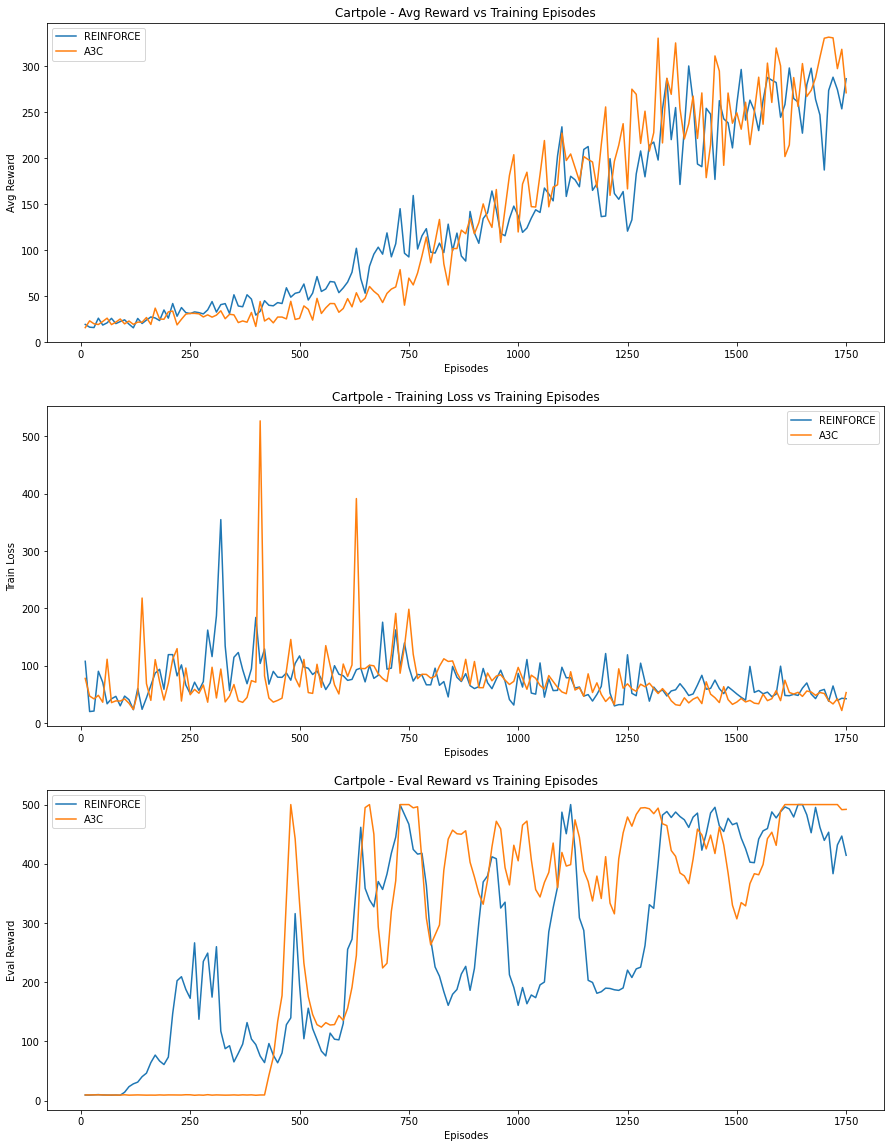

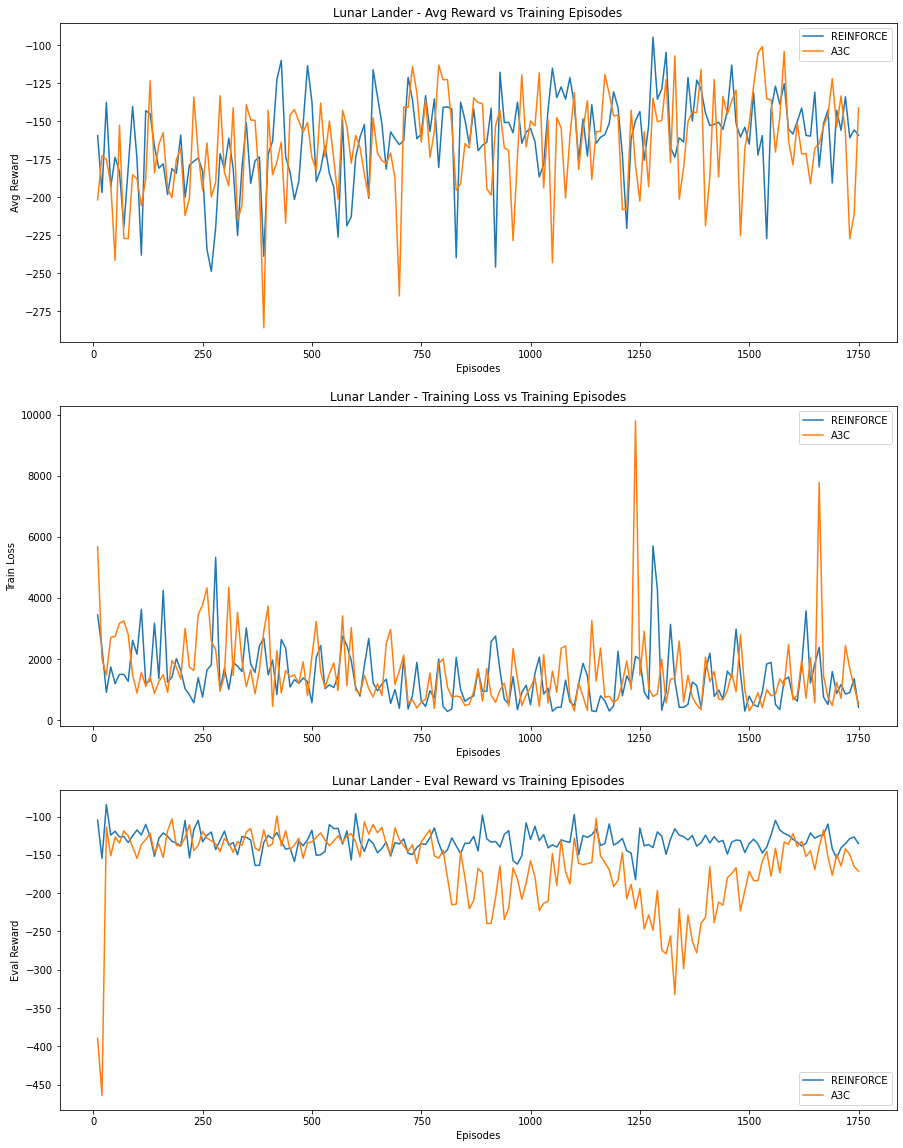

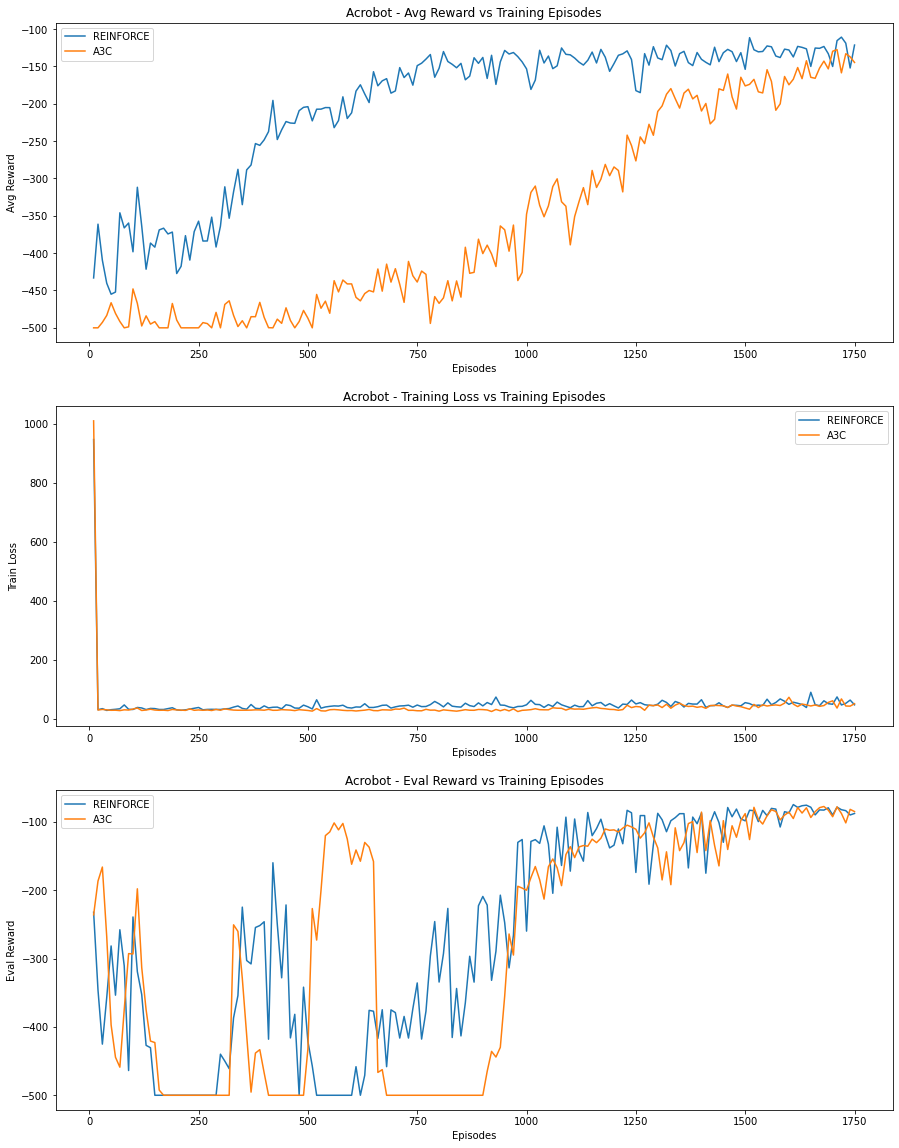

In [23]:
# Convergence Plots - Small

if CARTPOLE:
    with open('data/cartpoleREINFORCE_converge.pkl', 'rb') as cartpoleREINFORCE_conv:
        cpRDict_conv = pkl.load(cartpoleREINFORCE_conv)
        cpREINFORCE_conv_episode = cpRDict_conv['episodeList']
        cpREINFORCE_conv_totalReward = cpRDict_conv['totalRewardList']
        cpREINFORCE_conv_trainLoss = cpRDict_conv['trainLossList']
        cpREINFORCE_conv_evalReward = cpRDict_conv['evalRewardList']
        
    with open('data/cartpoleA3C_2000small.pkl', 'rb') as cartpoleA3C_conv:
        cpADict_conv = pkl.load(cartpoleA3C_conv)
        cpA3C_conv_episode = cpADict_conv['episodeList']
        cpA3C_conv_totalReward = cpADict_conv['totalRewardList']
        cpA3C_conv_trainLoss = cpADict_conv['trainLossList']
        cpA3C_conv_evalReward = cpADict_conv['evalRewardList']
    
    plt.figure(figsize=(15,20))
    plt.tight_layout()
    
    plt.subplot(3,1,1)
    plt.plot(cpREINFORCE_conv_episode[0:175], cpREINFORCE_conv_totalReward[0:175], label="REINFORCE")
    plt.plot(cpA3C_conv_episode[0:175], cpA3C_conv_totalReward[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Cartpole - Avg Reward vs Training Episodes')
    
    plt.subplot(3,1,2)
    plt.plot(cpREINFORCE_conv_episode[0:175], cpREINFORCE_conv_trainLoss[0:175], label="REINFORCE")
    plt.plot(cpA3C_conv_episode[0:175], cpA3C_conv_trainLoss[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Train Loss')
    plt.title('Cartpole - Training Loss vs Training Episodes')
    
    plt.subplot(3,1,3)
    plt.plot(cpREINFORCE_conv_episode[0:175], cpREINFORCE_conv_evalReward[0:175], label="REINFORCE")
    plt.plot(cpA3C_conv_episode[0:175], cpA3C_conv_evalReward[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Eval Reward')
    plt.title('Cartpole - Eval Reward vs Training Episodes')
    
    plt.savefig('outputImgs/CP_REINFORCEvA3C')
    
if LUNARLANDER:
    with open('data/lunarlanderREINFORCE_conv.pkl', 'rb') as lunarlanderREINFORCE_conv:
        llRDict_conv = pkl.load(lunarlanderREINFORCE_conv)
        llREINFORCE_conv_episode = llRDict_conv['episodeList']
        llREINFORCE_conv_totalReward = llRDict_conv['totalRewardList']
        llREINFORCE_conv_trainLoss = llRDict_conv['trainLossList']
        llREINFORCE_conv_evalReward = llRDict_conv['evalRewardList']
        
    with open('data/lunarlanderA3C_conv.pkl', 'rb') as lunarlanderA3C_conv:
        llADict_conv = pkl.load(lunarlanderA3C_conv)
        llA3C_conv_episode = llADict_conv['episodeList']
        llA3C_conv_totalReward = llADict_conv['totalRewardList']
        llA3C_conv_trainLoss = llADict_conv['trainLossList']
        llA3C_conv_evalReward = llADict_conv['evalRewardList']
    
    plt.figure(figsize=(15,20))
    plt.tight_layout()
    
    plt.subplot(3,1,1)
    plt.plot(llREINFORCE_conv_episode[0:175], llREINFORCE_conv_totalReward[0:175], label="REINFORCE")
    plt.plot(llA3C_conv_episode[0:175], llA3C_conv_totalReward[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Lunar Lander - Avg Reward vs Training Episodes')
    
    plt.subplot(3,1,2)
    plt.plot(llREINFORCE_conv_episode[0:175], llREINFORCE_conv_trainLoss[0:175], label="REINFORCE")
    plt.plot(llA3C_conv_episode[0:175], llA3C_conv_trainLoss[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Train Loss')
    plt.title('Lunar Lander - Training Loss vs Training Episodes')
    
    plt.subplot(3,1,3)
    plt.plot(llREINFORCE_conv_episode[0:175], llREINFORCE_conv_evalReward[0:175], label="REINFORCE")
    plt.plot(llA3C_conv_episode[0:175], llA3C_conv_evalReward[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Eval Reward')
    plt.title('Lunar Lander - Eval Reward vs Training Episodes')
    
    plt.savefig('outputImgs/LL_REINFORCEvA3C')
    
    
if ACROBAT:
    with open('data/acrobatREINFORCE_conv.pkl', 'rb') as acrobatREINFORCE_conv:
        abRDict_conv = pkl.load(acrobatREINFORCE_conv)
        abREINFORCE_conv_episode = abRDict_conv['episodeList']
        abREINFORCE_conv_totalReward = abRDict_conv['totalRewardList']
        abREINFORCE_conv_trainLoss = abRDict_conv['trainLossList']
        abREINFORCE_conv_evalReward = abRDict_conv['evalRewardList']
        
    with open('data/acrobatA3C_conv.pkl', 'rb') as acrobatA3C_conv:
        abADict_conv = pkl.load(acrobatA3C_conv)
        abA3C_conv_episode = abADict_conv['episodeList']
        abA3C_conv_totalReward = abADict_conv['totalRewardList']
        abA3C_conv_trainLoss = abADict_conv['trainLossList']
        abA3C_conv_evalReward = abADict_conv['evalRewardList']
    
    plt.figure(figsize=(15,20))
    plt.tight_layout()
    
    plt.subplot(3,1,1)
    plt.plot(abREINFORCE_conv_episode[0:175], abREINFORCE_conv_totalReward[0:175], label="REINFORCE")
    plt.plot(abA3C_conv_episode[0:175], abA3C_conv_totalReward[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.title('Acrobot - Avg Reward vs Training Episodes')
    
    plt.subplot(3,1,2)
    plt.plot(abREINFORCE_conv_episode[0:175], abREINFORCE_conv_trainLoss[0:175], label="REINFORCE")
    plt.plot(abA3C_conv_episode[0:175], abA3C_conv_trainLoss[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Train Loss')
    plt.title('Acrobot - Training Loss vs Training Episodes')
    
    plt.subplot(3,1,3)
    plt.plot(abREINFORCE_conv_episode[0:175], abREINFORCE_conv_evalReward[0:175], label="REINFORCE")
    plt.plot(abA3C_conv_episode[0:175], abA3C_conv_evalReward[0:175], label="A3C")
    
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Eval Reward')
    plt.title('Acrobot - Eval Reward vs Training Episodes')
    
    plt.savefig('outputImgs/AB_REINFORCEvA3C')
